<a href="https://colab.research.google.com/github/ljrn8/QuickNotebooks/blob/main/ab_resistance_genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Antibiotic Resistance Genes | Proof Of Concept
---
The situation is a simple binary classification on sequence data. The Dataset was original gathered from kaggle, but the author privated the dataset soon after I downloaded (not kidding).

###  Results:

all models consistantly get above 90% accuracy with little optimization

- MLP = 94%
- GRU = 97%
- CNN = 98%

In summary, resistance is easily identified through genes, predicting based off Pan / meta genomes will be less simple. Many improvements could have been made in light of future models.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

from functools import partial
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [ ]:
np_data = np.load('/content/drive/MyDrive/datasets/dataset.npy', allow_pickle=True)
np_data

array({'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTAC

In [ ]:
# thanks to Alexander Scarlat .MD for the pandas dataframe convertion
Datadict = np_data[()]
df = pd.DataFrame.from_dict(Datadict)
print(df.shape)
df

(100000, 2)


,resistant,genes
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...
...,...,...
99995,False,ATGCACTACCGTATGATTCACTGGATGATGGAAACTCTCTTTGACT...
99996,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
99997,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTG...
99998,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAAT...


In [ ]:
# gene
X = df['genes'].iloc[0]
print(len(X), X)

156 ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   resistant  100000 non-null  bool  
 1   genes      100000 non-null  object
dtypes: bool(1), object(1)
memory usage: 879.0+ KB


False    50297
True     49703
Name: resistant, dtype: int64


<Axes: >

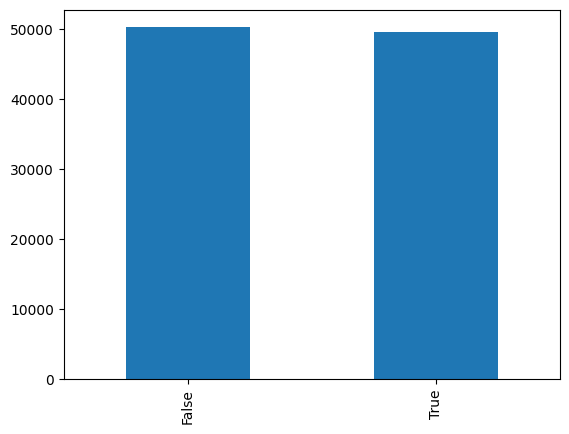

In [ ]:
val_counts = df["resistant"].value_counts()
print(val_counts)
val_counts.plot(kind="bar")

In [ ]:
from keras.utils import pad_sequences

vocab = ['A', 'C', 'G', 'T']
char2idx = {
  char: (idx+1) for idx, char in enumerate(vocab)
}

# tokenize (convert to ATGC to 1-4)
def tokenize(sequence):
  return [char2idx[char] for char in sequence]

# one hot encode (convert to sparse vector)
def encode(tokens):
  tensor = tf.constant(tokens)
  one_hot = np.asarray(tf.one_hot(tensor, len(vocab)))
  return one_hot.astype("int32")

df['genes_tokenized'] = df['genes'].apply(tokenize)

# pad right with 0's for the tokenized column
X_token = pad_sequences(df['genes_tokenized'], maxlen=160, padding='post', truncating='post', value=0)

X_enc = np.array([encode(tokens) for tokens in X_token])

print(df.head(3))
print("OHE:\n ", X_enc[0][0][:5], "\n .... ")

   resistant                                              genes  \
0      False  ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...   
1      False  ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...   
2      False  ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...   

                                     genes_tokenized  
0  [1, 4, 3, 2, 1, 2, 4, 1, 2, 2, 3, 4, 1, 4, 3, ...  
1  [1, 4, 3, 2, 1, 2, 4, 1, 2, 2, 3, 4, 1, 4, 3, ...  
2  [1, 4, 3, 2, 1, 2, 4, 1, 2, 2, 3, 4, 1, 4, 3, ...  
OHE:
  [0 1 0 0] 
 .... 


In [ ]:
y = np.array(df['resistant']).astype('int32')

def split(X, ratio=0.8):
  # take out test set (top 20%)
  test_split = int(len(X) * ratio)
  full_train, test = X[:test_split], X[test_split:]

  # hold out top 20% of training for per epoch validation
  validation_split = int(len(full_train) * ratio)
  train, validation = full_train[:validation_split], full_train[validation_split:]

  return train, validation, test

y_train, y_valid, y_test = split(y)
X_enc_train, X_enc_valid, X_enc_test = split(X_enc)
X_token_train, X_token_valid, X_token_test = split(X_token)

# SVM

In [ ]:
''' from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_token_train, y_train)

y_pred = svm.predict(X_token_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred) '''

# colab dies -> to much data for non parametric

' from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score\nfrom sklearn.svm import SVC\n\nsvm = SVC(kernel=\'linear\')\nsvm.fit(X_token_train, y_train)\n\ny_pred = svm.predict(X_token_test)\n\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy: ", accuracy)\n\nConfusionMatrixDisplay.from_predictions(y_test, y_pred) '

# MLP

In [ ]:
DefaultDense = partial(
  layers.Dense,
  activation='relu',
  kernel_initializer="he_uniform",
  kernel_regularizer= keras.regularizers.l2(0.01)
)
mlp_model = keras.Sequential([
    keras.Input(160),
    DefaultDense(20), # technically not a MLP cos 2 hidden layers but who cares
    DefaultDense(10),
    layers.Dense(1, activation='sigmoid')
])
mlp_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 20)                3220      
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3) # stop training if overfits
mlp_history = mlp_model.fit(X_token_train, y_train, epochs=7, batch_size=32,
                    validation_data=(X_token_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/7
2000/2000 [==============================] - 11s 4ms/step - loss: 0.5642 - accuracy: 0.8198 - val_loss: 0.4192 - val_accuracy: 0.8253
Epoch 2/7
2000/2000 [==============================] - 7s 4ms/step - loss: 0.3807 - accuracy: 0.8690 - val_loss: 0.3375 - val_accuracy: 0.8997
Epoch 3/7
2000/2000 [==============================] - 7s 4ms/step - loss: 0.3240 - accuracy: 0.8942 - val_loss: 0.3045 - val_accuracy: 0.8778
Epoch 4/7
2000/2000 [==============================] - 8s 4ms/step - loss: 0.2894 - accuracy: 0.9073 - val_loss: 0.2623 - val_accuracy: 0.9394
Epoch 5/7
2000/2000 [==============================] - 7s 4ms/step - loss: 0.2677 - accuracy: 0.9138 - val_loss: 0.3057 - val_accuracy: 0.8553
Epoch 6/7
2000/2000 [==============================] - 8s 4ms/step - loss: 0.2536 - accuracy: 0.9183 - val_loss: 0.2251 - val_accuracy: 0.9302
Epoch 7/7
2000/2000 [==============================] - 7s 3ms/step - loss: 0.2382 - accuracy: 0.9226 - val_loss: 0.2163 - val_accuracy: 0.940

<Axes: >

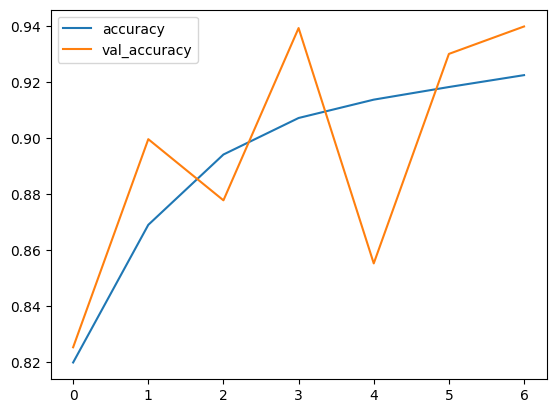

In [ ]:
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot()

625/625 [==============================] - 3s 4ms/step
Accuracy:  0.94245


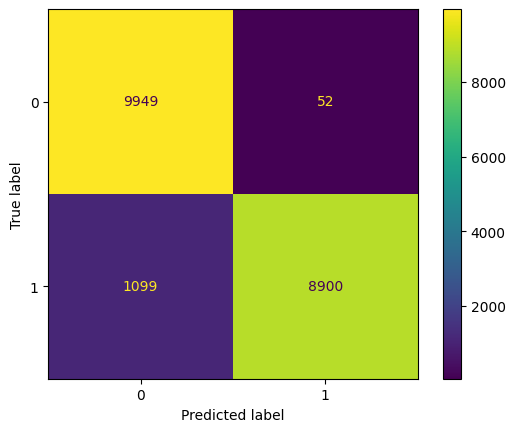

In [ ]:
y_pred = mlp_model.predict(X_token_test)
y_pred = (y_pred > 0.5).astype("int32")
mlp_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", mlp_accuracy)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))

# GRU

In [ ]:
gru_model = keras.Sequential([
    layers.Bidirectional(
        # bidirection wrapper converts LSTM to GRU
        layers.LSTM(100, kernel_initializer='he_normal',
                    # kernel_regularizer='l2',
                    # dropout=0.3,
                    activation='tanh'),
        input_shape=(160, 4)
    ),
    # add another dense?
    layers.Dense(1, activation='sigmoid')
])
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 200)              84000     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 84,201
Trainable params: 84,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
gru_history = gru_model.fit(X_enc_train, y_train, epochs=7, batch_size=32,
                    validation_data=(X_enc_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/7
2000/2000 [==============================] - 39s 18ms/step - loss: 0.4432 - accuracy: 0.7350 - val_loss: 0.2594 - val_accuracy: 0.8799
Epoch 2/7
2000/2000 [==============================] - 36s 18ms/step - loss: 0.2597 - accuracy: 0.8619 - val_loss: 0.2513 - val_accuracy: 0.8722
Epoch 3/7
2000/2000 [==============================] - 35s 17ms/step - loss: 0.2255 - accuracy: 0.8869 - val_loss: 0.2157 - val_accuracy: 0.8968
Epoch 4/7
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1987 - accuracy: 0.9018 - val_loss: 0.1527 - val_accuracy: 0.9444
Epoch 5/7
2000/2000 [==============================] - 38s 19ms/step - loss: 0.3001 - accuracy: 0.8568 - val_loss: 0.1974 - val_accuracy: 0.9073
Epoch 6/7
2000/2000 [==============================] - 31s 15ms/step - loss: 0.1954 - accuracy: 0.9114 - val_loss: 0.1858 - val_accuracy: 0.9140
Epoch 7/7
2000/2000 [==============================] - 30s 15ms/step - loss: 0.1679 - accuracy: 0.9192 - val_loss: 0.0688 - val_ac

<Axes: >

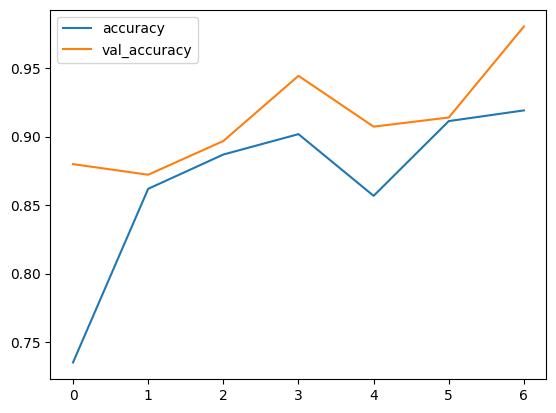

In [ ]:
pd.DataFrame(gru_history.history)[['accuracy', 'val_accuracy']].plot()

overfits; should re-add dropout/regularization

625/625 [==============================] - 5s 6ms/step
Accuracy:  0.9799


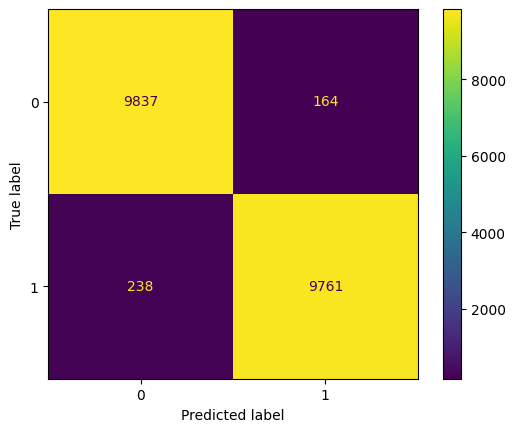

In [ ]:
y_pred = gru_model.predict(X_enc_test)
y_pred = (y_pred > 0.5).astype("int32")
gru_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", gru_accuracy)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))

# CNN

In [ ]:
DefaultConv = partial(layers.Conv1D, kernel_size=3, strides=1, use_bias=False,
                        padding='same', kernel_initializer='he_normal')

cnn_model = keras.Sequential([

  DefaultConv(32, strides=1, input_shape=(160, 4)),

  layers.Dropout(0.4),

  layers.MaxPooling1D(3, strides=2),

  DefaultConv(64),

  layers.MaxPooling1D(2, strides=2),

  layers.Flatten(),

  layers.Dropout(0.4),

  layers.Dense(64, activation="relu"),

  layers.Dense(1, activation="sigmoid")

])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 160, 32)           384       
                                                                 
 dropout_6 (Dropout)         (None, 160, 32)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 79, 32)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 79, 64)            6144      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 39, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2496)             

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3)
cnn_history = cnn_model.fit(X_enc_train, y_train, epochs=15, batch_size=32,
                    validation_data=(X_enc_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/15
2000/2000 [==============================] - 10s 4ms/step - loss: 0.3479 - accuracy: 0.7920 - val_loss: 0.2171 - val_accuracy: 0.9699
Epoch 2/15
2000/2000 [==============================] - 9s 4ms/step - loss: 0.2311 - accuracy: 0.8895 - val_loss: 0.1432 - val_accuracy: 0.9650
Epoch 3/15
2000/2000 [==============================] - 8s 4ms/step - loss: 0.1686 - accuracy: 0.9274 - val_loss: 0.1595 - val_accuracy: 0.8916
Epoch 4/15
2000/2000 [==============================] - 8s 4ms/step - loss: 0.1372 - accuracy: 0.9447 - val_loss: 0.0948 - val_accuracy: 0.9730
Epoch 5/15
2000/2000 [==============================] - 9s 5ms/step - loss: 0.1126 - accuracy: 0.9576 - val_loss: 0.0921 - val_accuracy: 0.9721
Epoch 6/15
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0960 - accuracy: 0.9661 - val_loss: 0.1057 - val_accuracy: 0.9693
Epoch 7/15
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0875 - accuracy: 0.9707 - val_loss: 0.0513 - val_accuracy

<Axes: >

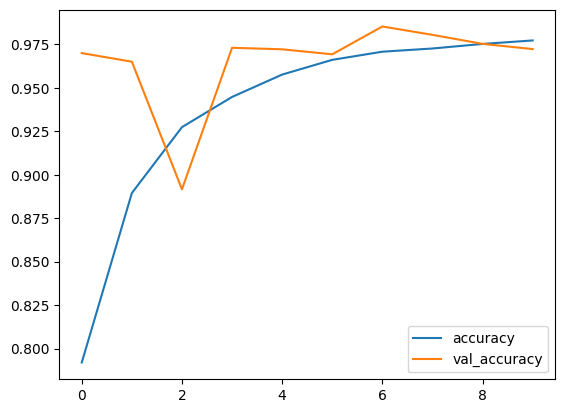

In [ ]:
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

625/625 [==============================] - 1s 2ms/step
Accuracy:  0.97245


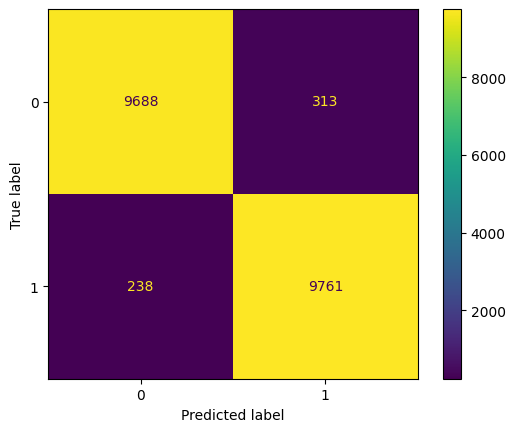

In [ ]:
y_pred = cnn_model.predict(X_enc_test)
y_pred = (y_pred > 0.5).astype("int32")
cnn_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", cnn_accuracy)
print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred))

# Improvements that could have been made

- padding sequences is lazy and not sutable for GRU; real scenario would make use of variable length sequences

- Didnt use "k-mer" strategy in from papers - again would have increased accuracy.

- Hyper params werent optimized

- didnt use codons

- a combination of GRU and CNN would be perfect for longer sequences